The unstaggered case blows up for both the Euler explicit and Leap frog case. We move on to the staggered grid in 2D domain, and apply both the Euler explicit and Leap Frog scheme. The equations of motion are:

$$ \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y} - fv = - g \frac{\partial h}{\partial x} $$

$$ \frac{\partial v}{\partial t} + u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y} + fu = - g \frac{\partial h}{\partial y} $$

$$ \frac{\partial h}{\partial t} + \frac{\partial (uh)}{\partial x} + \frac{\partial (vh)}{\partial y} = 0$$

We use the following staggered grid:

     ----v---- ----v---- ----v----
    |    |    |    |    |    |    |
    u----h----u----h----u----h----u
    |    |    |    |    |    |    |
     ----v---- ----v---- ----v----
    |    |    |    |    |    |    |
    u----h----u----h----u----h----u
    |    |    |    |    |    |    |
     ----v---- ----v---- ----v----
    |    |    |    |    |    |    |
    u----h----u----h----u----h----u
    |    |    |    |    |    |    |
     ----v---- ----v---- ----v----

On this grid, nx = 3, ny = 3. um_avg = np.zeros((nx-2,ny-1)).

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Video
from matplotlib import animation
from mpl_toolkits import mplot3d

In [2]:
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

import Euler.Periodic_2D as elr

## Euler explicit scheme

In [3]:
#Defining constants

g = 9.81
r0 = 6.378*10**6
day = 24*60*60
omega = 2*np.pi / day
f = 2*omega*np.sin(np.deg2rad(30))

In [4]:
Lx, Ly = 3, 3
nx, ny = 100, 100
dx, dy = Lx/nx, Ly/ny

x1 = np.linspace(-Lx, Lx - dx/2, nx+1, dtype = float)
x2 = x1 + dx/2
x2 = x2[0:-1]

y1 = np.linspace(-Ly, Ly - dy/2, ny+1, dtype = float)
y2 = y1 + dy/2
y2 = y2[0:-1]

Xt, Yt = np.meshgrid(x2, y2)
Xu, Yu = np.meshgrid(x1, y2)
Xv, Yv = np.meshgrid(x2, y1)

In [5]:
um_old = np.zeros((nx+1, ny))
um_new = np.zeros((nx+1, ny))
vm_old = np.zeros((nx, ny+1))
vm_new = np.zeros((nx, ny+1))

um_avg = np.zeros((nx, ny-1))
vm_avg = np.zeros((nx-1, ny))

hm_old = 1 + 0.01*np.exp(-10*(Xt**2 + Yt**2))
hm_old_t0 = 1 + 0.01*np.exp(-10*(Xt**2 + Yt**2))
hm_new = np.zeros((nx, ny))

t_start = 0
t_end = 10
dt = 0.01

# Needed to create animations
um_data = np.zeros(((nx+1, ny, int(t_end/dt) + 1)))
vm_data = np.zeros(((nx, ny+1, int(t_end/dt) + 1)))
hm_data = np.zeros(((nx, ny, int(t_end/dt) + 1)))

for t in np.arange(t_start,t_end,dt):
    
    um_avg = 0.25*(um_old[0:nx, 0:ny-1] + um_old[0:nx, 1:ny] + um_old[1:nx+1, 0:ny-1] + um_old[1:nx+1, 1:ny])
    vm_avg = 0.25*(vm_old[0:nx-1, 0:ny] + vm_old[1:nx, 0:ny] + vm_old[0:nx-1, 1:ny+1] + vm_old[1:nx, 1:ny+1])
    
    # Governing equations for interior points
    um_new[1:nx, 1:ny-1] = um_old[1:nx, 1:ny-1] - dt*(um_old[1:nx, 1:ny-1] * elr.partial_x_cd(um_old, dx, nx)[1:nx, 1:ny-1] - vm_avg[:, 1:-1] * elr.partial_y_cd(
        um_old, dx, nx)[1:nx, 1:ny-1] + f*vm_avg[:, 1:-1] - g * (1/dx) * (hm_old[1:, 1:-1] - hm_old[0:-1, 1:-1]))
    vm_new[1:nx-1, 1:ny] = vm_old[1:nx-1, 1:ny] - dt*(um_avg[1:-1, :] * elr.partial_x_cd(vm_old, dy, ny)[1:nx-1, 1:ny] - vm_old[1:nx-1, 1:ny] * elr.partial_y_cd(
        vm_old, dy, ny)[1:nx-1, 1:ny] - f*um_avg[1:-1 ,:] - g * (1/dy) * (hm_old[1:-1, 1:] - hm_old[1:-1, 0:-1]))
    hm_new[1:nx-1, 1:ny-1] = hm_old[1:nx-1, 1:ny-1] - 0.5*dt*((um_old[1:nx-1,1:ny-1] + um_old[2:nx, 1:ny-1]) * elr.partial_x_cd(
        hm_old, dx, nx)[1:nx-1, 1:ny-1] - 0.5 * (vm_old[1:nx-1, 1:ny-1] + vm_old[1:nx-1, 2:ny]) * elr.partial_y_cd(
        hm_old, dy, ny)[1:nx-1, 1:ny-1] - 0.5 * hm_old[1:nx-1, 1:ny-1] * (1/dx) * (um_old[2:nx, 1:ny-1] - um_old[1:nx-1, 1:ny-1]) - hm_old[1:nx-1, 1:ny-1] * (1/dy) * (
        vm_old[1:nx-1, 2:ny] - vm_old[1:nx-1, 1:ny-1]))
    
    # Periodic boundary conditions
    um_new[0, :] = um_new[-2, :]
    um_new[-1, :] = um_new[1, :]
    um_new[:, 0] = um_new[:, -2]
    um_new[:, -1] = um_new[:, 1]
    
    vm_new[:, 0] = vm_new[:, -2]
    vm_new[:, -1] = vm_new[:, 1]
    vm_new[0, :] = vm_new[-2, :]
    vm_new[-1, :] = vm_new[1, :]
    
    hm_new[0, :] = hm_new[-2, :]
    hm_new[-1, :] = hm_new[1, :]
    hm_new[:, 0] = hm_new[:, -2]
    hm_new[:, -1] = hm_new[:, 1]
    
    um_data[:, :, int(t/dt)] = um_new
    vm_data[:, :, int(t/dt)] = vm_new
    hm_data[:, :, int(t/dt)] = hm_new
    
    hm_old = hm_new
    um_old = um_new
    vm_old = vm_new

In [14]:
fig,ax = plt.subplots(figsize = (13,5))

def update_fig(i):
    
    plt.clf()
    plt.title('Wave height for time = ' + str(dt*i))
    p1 = plt.contourf(Xt, Yt, hm_data[:,:,i], levels = np.linspace(0.996, 1.004, 21), cmap = 'RdBu')
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    return p1

num_frames = int(t_end/dt)
anim = animation.FuncAnimation(fig, update_fig, frames = num_frames, blit = False)
anim.save('Videos/2D_SWE_Cons_hm.mp4',writer = 'ffmpeg',fps = 8)

plt.close(anim._fig)

Video('Videos/2D_SWE_Cons_hm.mp4')

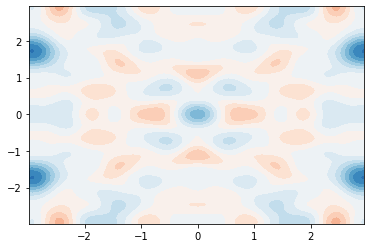

In [15]:
plt.contourf(Xt, Yt, hm_new, levels = np.linspace(0.996, 1.004, 21), cmap = 'RdBu')

## Leap Frog scheme

In [16]:
Lx, Ly = 3, 3
nx, ny = 100, 100
dx, dy = Lx/nx, Ly/ny

x1 = np.linspace(-Lx, Lx - dx/2, nx+1, dtype = float)
x2 = x1 + dx/2
x2 = x2[0:-1]

y1 = np.linspace(-Ly, Ly - dy/2, ny+1, dtype = float)
y2 = y1 + dy/2
y2 = y2[0:-1]

In [28]:
Xt, Yt = np.meshgrid(x2, y2)
Xu, Yu = np.meshgrid(x1, y2)
Xv, Yv = np.meshgrid(x2, y1)

um_older = np.zeros((nx+1, ny))
um_old = np.zeros((nx+1, ny))
um_new = np.zeros((nx+1, ny))

vm_older = np.zeros((nx, ny+1))
vm_old = np.zeros((nx, ny+1))
vm_new = np.zeros((nx, ny+1))

um_avg = np.zeros((nx, ny-1))
vm_avg = np.zeros((nx-1, ny))

hm_older = np.zeros((nx, ny))
hm_old = 1 + 0.01*np.exp(-10*(Xt**2 + Yt**2))
hm_old_t0 = 1 + 0.01*np.exp(-10*(Xt**2 + Yt**2))
hm_new = np.zeros((nx, ny))

t_start = 0
t_end = 5
dt = 0.001

# Needed to create animations
um_data = np.zeros(((nx+1, ny, int(t_end/dt) + 1)))
vm_data = np.zeros(((nx, ny+1, int(t_end/dt) + 1)))
hm_data = np.zeros(((nx, ny, int(t_end/dt) + 1)))

count = 0

for t in np.arange(t_start,t_end,dt):
    
    um_avg = 0.25*(um_old[0:nx, 0:ny-1] + um_old[0:nx, 1:ny] + um_old[1:nx+1, 0:ny-1] + um_old[1:nx+1, 1:ny])
    vm_avg = 0.25*(vm_old[0:nx-1, 0:ny] + vm_old[1:nx, 0:ny] + vm_old[0:nx-1, 1:ny+1] + vm_old[1:nx, 1:ny+1])
    
    if(count == 0):
        # Governing equations for interior points
        um_new[1:nx, 1:ny-1] = um_old[1:nx, 1:ny-1] - dt*(um_old[1:nx, 1:ny-1] * elr.partial_x_cd(um_old, dx, nx)[1:nx, 1:ny-1] - vm_avg[:, 1:-1] * elr.partial_y_cd(
            um_old, dx, nx)[1:nx, 1:ny-1] + f*vm_avg[:, 1:-1] - g * (1/dx) * (hm_old[1:, 1:-1] - hm_old[0:-1, 1:-1]))
        vm_new[1:nx-1, 1:ny] = vm_old[1:nx-1, 1:ny] - dt*(um_avg[1:-1, :] * elr.partial_x_cd(vm_old, dy, ny)[1:nx-1, 1:ny] - vm_old[1:nx-1, 1:ny] * elr.partial_y_cd(
            vm_old, dy, ny)[1:nx-1, 1:ny] - f*um_avg[1:-1 ,:] - g * (1/dy) * (hm_old[1:-1, 1:] - hm_old[1:-1, 0:-1]))
        hm_new[1:nx-1, 1:ny-1] = hm_old[1:nx-1, 1:ny-1] - 0.5*dt*((um_old[1:nx-1,1:ny-1] + um_old[2:nx, 1:ny-1]) * elr.partial_x_cd(
            hm_old, dx, nx)[1:nx-1, 1:ny-1] - 0.5 * (vm_old[1:nx-1, 1:ny-1] + vm_old[1:nx-1, 2:ny]) * elr.partial_y_cd(
            hm_old, dy, ny)[1:nx-1, 1:ny-1] - 0.5 * hm_old[1:nx-1, 1:ny-1] * (1/dx) * (um_old[2:nx, 1:ny-1] - um_old[1:nx-1, 1:ny-1]) - hm_old[1:nx-1, 1:ny-1] * (1/dy) * (
            vm_old[1:nx-1, 2:ny] - vm_old[1:nx-1, 1:ny-1]))
    else:
        # Governing equations for interior points
        um_new[1:nx, 1:ny-1] = um_older[1:nx, 1:ny-1] - 2*dt*(um_old[1:nx, 1:ny-1] * elr.partial_x_cd(um_old, dx, nx)[1:nx, 1:ny-1] - vm_avg[:, 1:-1] * elr.partial_y_cd(
            um_old, dx, nx)[1:nx, 1:ny-1] + f*vm_avg[:, 1:-1] - g * (1/dx) * (hm_old[1:, 1:-1] - hm_old[0:-1, 1:-1]))
        vm_new[1:nx-1, 1:ny] = vm_older[1:nx-1, 1:ny] - 2*dt*(um_avg[1:-1, :] * elr.partial_x_cd(vm_old, dy, ny)[1:nx-1, 1:ny] - vm_old[1:nx-1, 1:ny] * elr.partial_y_cd(
            vm_old, dy, ny)[1:nx-1, 1:ny] - f*um_avg[1:-1 ,:] - g * (1/dy) * (hm_old[1:-1, 1:] - hm_old[1:-1, 0:-1]))
        hm_new[1:nx-1, 1:ny-1] = hm_older[1:nx-1, 1:ny-1] - 0.5*2*dt*((um_old[1:nx-1,1:ny-1] + um_old[2:nx, 1:ny-1]) * elr.partial_x_cd(
            hm_old, dx, nx)[1:nx-1, 1:ny-1] - 0.5 * (vm_old[1:nx-1, 1:ny-1] + vm_old[1:nx-1, 2:ny]) * elr.partial_y_cd(
            hm_old, dy, ny)[1:nx-1, 1:ny-1] - 0.5 * hm_old[1:nx-1, 1:ny-1] * (1/dx) * (um_old[2:nx, 1:ny-1] - um_old[1:nx-1, 1:ny-1]) - hm_old[1:nx-1, 1:ny-1] * (1/dy) * (
            vm_old[1:nx-1, 2:ny] - vm_old[1:nx-1, 1:ny-1]))
        
    # Periodic boundary conditions
    um_new[0, :] = um_new[-2, :]
    um_new[-1, :] = um_new[1, :]
    um_new[:, 0] = um_new[:, -2]
    um_new[:, -1] = um_new[:, 1]
    
    vm_new[:, 0] = vm_new[:, -2]
    vm_new[:, -1] = vm_new[:, 1]
    vm_new[0, :] = vm_new[-2, :]
    vm_new[-1, :] = vm_new[1, :]
    
    hm_new[0, :] = hm_new[-2, :]
    hm_new[-1, :] = hm_new[1, :]
    hm_new[:, 0] = hm_new[:, -2]
    hm_new[:, -1] = hm_new[:, 1]
    
    um_data[:, :, int(t/dt)] = um_new
    vm_data[:, :, int(t/dt)] = vm_new
    hm_data[:, :, int(t/dt)] = hm_new
    
    hm_older = hm_old
    um_older = um_old
    vm_older = vm_old
    
    hm_old = hm_new
    um_old = um_new
    vm_old = vm_new
    
    count = count + 1

In [30]:
fig,ax = plt.subplots(figsize = (13,5))

def update_fig(i):
    
    plt.clf()
    plt.title('Wave height for time = ' + str(dt*i*10))
    p1 = plt.contourf(Xt, Yt, hm_data[:,:,i*10], levels = np.linspace(0.996, 1.004, 21), cmap = 'RdBu')
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    return p1

num_frames = int(t_end/dt/10)
anim = animation.FuncAnimation(fig, update_fig, frames = num_frames, blit = False)
anim.save('Videos/2D_SWE_Cons_LF_hm.mp4',writer = 'ffmpeg',fps = 8)

plt.close(anim._fig)

Video('Videos/2D_SWE_Cons_LF_hm.mp4')